In [55]:
import pandas as pd
import numpy as np
import os 
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from scipy.stats import pearsonr
from sklearn.decomposition import PCA

### Read metainfo

In [28]:
metainfo = pd.read_csv('../data/meta/metainfo.csv', sep=',', index_col=0, dtype={'URL': object}).reset_index()
metainfo.head()

,index,Row,Column,Field,URL,R-C,GFP,natMX4,pairs
0,0,1,1,1,001001001,1-1,KIN1,NaN,KIN1-KIN2
1,1,1,1,2,001001002,1-1,KIN1,NaN,KIN1-KIN2
2,2,1,1,3,001001003,1-1,KIN1,NaN,KIN1-KIN2
3,3,1,1,4,001001004,1-1,KIN1,NaN,KIN1-KIN2
4,4,1,2,1,001002001,1-2,KIN2,NaN,KIN1-KIN2


In [99]:
pairs = np.unique(metainfo.pairs)
pair = pairs[0]
pair

'AAP1-APE2'

In [30]:
metainfo_pair = pd.read_csv(f'../data/meta/metainfo_replicate*_{pair}.csv', index_col=0)
metainfo_pair.head()

,URL,replicate,cell_id,file,Row,Column,Field,R-C,GFP,natMX4,pairs,label,class,abundance,abundance_repl_std
0,5019001,replicate1,0000.npy,../data/frames/replicate1/005019001/0000.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,31.602539,0.000862
1,5019001,replicate1,0001.npy,../data/frames/replicate1/005019001/0001.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,41.653809,0.204755
2,5019001,replicate1,0002.npy,../data/frames/replicate1/005019001/0002.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,54.278564,0.460853
3,5019001,replicate1,0003.npy,../data/frames/replicate1/005019001/0003.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,53.708496,0.449289
4,5019001,replicate1,0004.npy,../data/frames/replicate1/005019001/0004.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,67.809082,0.735324


### Calculate protein abundance 

We calculate protein abundance as per-cell average pixel intensity

In [11]:
def calculate_intensity(img, reduce='mean'):
    assert reduce in ('mean', 'median', 'max')
    return eval(f'np.{reduce}')(img)

In [48]:
def calculate_protein_abundance(metainfo, reduce='mean'):
    metainfo['abundance'] = [calculate_intensity(np.load(fn), reduce) for fn in tqdm(metainfo.file, leave=False)]
    return metainfo

In [49]:
metainfo_pair = calculate_protein_abundance(metainfo_pair)

In [104]:
metainfo_pair.head()

,URL,replicate,cell_id,file,Row,Column,Field,R-C,GFP,natMX4,pairs,label,class,abundance
0,5019001,replicate1,0000.npy,../data/frames/replicate1/005019001/0000.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,31.602539
1,5019001,replicate1,0001.npy,../data/frames/replicate1/005019001/0001.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,41.653809
2,5019001,replicate1,0002.npy,../data/frames/replicate1/005019001/0002.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,54.278564
3,5019001,replicate1,0003.npy,../data/frames/replicate1/005019001/0003.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,53.708496
4,5019001,replicate1,0004.npy,../data/frames/replicate1/005019001/0004.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,67.809082


In [46]:
def plot_abundance_boxplots(metainfo_pair, y='abundance', logscale=True, separate_replicates=True, save=False, save_path='../results/abundance/'):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    pair = np.unique(metainfo_pair.GFP)
    for i, (gene, ax) in enumerate(zip(pair, axes)):
        sns.boxplot(data=metainfo_pair[metainfo_pair.GFP==gene], x='label', y=y, hue='replicate' if separate_replicates else None, ax=ax)
        labels = [item.get_text().replace(' ', '\n') for item in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
        ax.set_title(gene)
        if logscale:
            ax.set(yscale="log")
    plt.tight_layout()
    if save:
        pair = "-".join(pair)
        plt.savefig(f'{save_path}/{pair}.png')
        fig.clear()
    else:
        plt.show()
    return

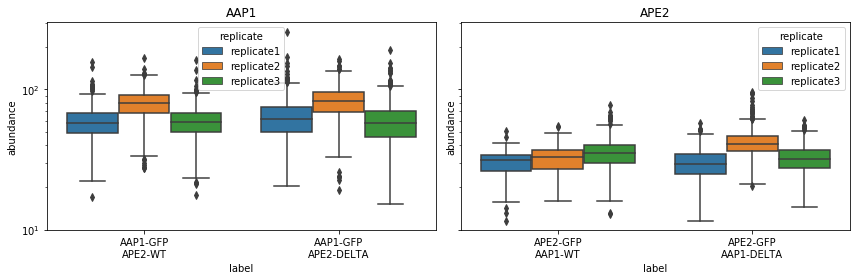

In [101]:
plot_abundance_boxplots(metainfo_pair)

In [35]:
def calculate_protein_abundance_all_pairs(update_metainfo=True, reduce='mean'):
    metainfo = pd.read_csv('../data/meta/metainfo.csv', sep=',', index_col=0, dtype={'URL': object}).reset_index()
    for pair in tqdm(np.unique(metainfo.pairs)):
        fn = f'../data/meta/metainfo_replicate*_{pair}.csv'
        metainfo_pair = pd.read_csv(fn, index_col=0)
        if 'abundance' not in metainfo_pair.columns:
            metainfo_pair = calculate_protein_abundance(metainfo_pair, reduce)
            if update_metainfo:
                metainfo_pair.to_csv(fn)
        plot_abundance_boxplots(metainfo_pair, save=True)

In [ ]:
calculate_protein_abundance_all_pairs()

We can aggregate protein abundance by replicate and label to evaluate relative changes

In [36]:
def aggregate_protein_abundance(by=('replicate', 'label'), agg_column='abundance'):
    metainfo = pd.read_csv('../data/meta/metainfo.csv', sep=',', index_col=0, dtype={'URL': object}).reset_index()
    if isinstance(by, str):
        by = [by]
    results = []
    for pair in tqdm(np.unique(metainfo.pairs)):
        if pair.startswith('control'):
            continue
        metainfo_pair = pd.read_csv(f'../data/meta/metainfo_replicate*_{pair}.csv', index_col=0).loc[:, ['pairs', *by, agg_column]]
        metainfo_pair = metainfo_pair.groupby(['pairs', *by]).mean()
        results.append(metainfo_pair)
    results = pd.concat(results)
    return results

In [37]:
aggregated_abundance = aggregate_protein_abundance()

  0%|          | 0/92 [00:00<?, ?it/s]

In [39]:
aggregated_abundance.head()

abundance
pairs     replicate  label                         
AAP1-APE2 replicate1 AAP1-GFP APE2-DELTA  65.014016
                     AAP1-GFP APE2-WT     59.956622
                     APE2-GFP AAP1-DELTA  30.252105
                     APE2-GFP AAP1-WT     30.412981
          replicate2 AAP1-GFP APE2-DELTA  83.056090

In [128]:
aggregated_abundance.to_csv('../results/protein_abundance.csv')

### Standardize abundance by replicate mean and std

Aggregate per-replicate abundance sum and cell counts to obtain the mean and std 

In [94]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = f"percentile_{n:02d}"
    return percentile_


In [40]:
def standardize_abundance():
    metainfo = pd.read_csv('../data/meta/metainfo.csv', sep=',', index_col=0, dtype={'URL': object}).reset_index()

    abundances = [pd.read_csv(f'../data/meta/metainfo_replicate*_{pair}.csv').loc[:, ["replicate", "abundance"]] 
                  for pair in tqdm(np.unique(metainfo.pairs)) if pair != "control"]    
    abundances = pd.concat(abundances)
    abundance_statistics = abundances.groupby("replicate").agg(["mean", "std"])
    
    for pair in tqdm(np.unique(metainfo.pairs)):
        if pair == "control":
            continue

        fn = f"../data/meta/metainfo_replicate*_{pair}.csv"
        metainfo_pair = pd.read_csv(fn, index_col=0)
        for replicate_id in range(1, 4):
            replicate = f"replicate{replicate_id}"
            mu = abundance_statistics.loc[replicate, "abundance"]["mean"]
            std = abundance_statistics.loc[replicate, "abundance"]["std"]

            abundance_repl_std = (metainfo_pair.loc[metainfo_pair.replicate == replicate, "abundance"] - mu) / std
            metainfo_pair.loc[metainfo_pair.replicate == replicate, "abundance_repl_std"] = abundance_repl_std

        metainfo_pair.to_csv(fn)
    
    return abundance_statistics

In [96]:
def percentile_normalize_abundance(p_min=1, p_max=99):
    metainfo = pd.read_csv('../data/meta/metainfo.csv', sep=',', index_col=0, dtype={'URL': object}).reset_index()

    abundances = [pd.read_csv(f'../data/meta/metainfo_replicate*_{pair}.csv').loc[:, ["replicate", "abundance"]] 
                  for pair in tqdm(np.unique(metainfo.pairs)) if pair != "control"]    
    abundances = pd.concat(abundances)
    abundance_statistics = abundances.groupby("replicate").agg([percentile(p_min), percentile(p_max)])
    
    for pair in tqdm(np.unique(metainfo.pairs)):
        if pair == "control":
            continue

        fn = f"../data/meta/metainfo_replicate*_{pair}.csv"
        metainfo_pair = pd.read_csv(fn, index_col=0)
        for replicate_id in range(1, 4):
            replicate = f"replicate{replicate_id}"
            p_min_value = abundance_statistics.loc[replicate, "abundance"][f"percentile_{p_min:02d}"]
            p_max_value = abundance_statistics.loc[replicate, "abundance"][f"percentile_{p_max:02d}"]

            abundance_repl_pnorm = (metainfo_pair.loc[metainfo_pair.replicate == replicate, "abundance"] - p_min_value) / (p_max_value - p_min_value)
            metainfo_pair.loc[metainfo_pair.replicate == replicate, "abundance_repl_pnorm"] = abundance_repl_pnorm

        metainfo_pair.to_csv(fn)
    
    return abundance_statistics

In [41]:
abundance_statistics = standardize_abundance()
abundance_statistics

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

abundance           
                 mean        std
replicate                       
replicate1  31.560045  49.296710
replicate2  46.543268  95.004610
replicate3  36.591180  78.319681

In [97]:
abundance_statistics_percentile = percentile_normalize_abundance()
abundance_statistics_percentile

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

abundance              
           percentile_01 percentile_99
replicate                             
replicate1     10.620850    233.777725
replicate2     13.530117    584.773125
replicate3     11.791211    482.245410

In [100]:
metainfo_pair = pd.read_csv(f'../data/meta/metainfo_replicate*_{pair}.csv', index_col=0)
metainfo_pair.head()

,URL,replicate,cell_id,file,Row,Column,Field,R-C,GFP,natMX4,pairs,label,class,abundance,abundance_repl_std,abundance_repl_pnorm
0,5019001,replicate1,0000.npy,../data/frames/replicate1/005019001/0000.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,31.602539,0.000862,0.094022
1,5019001,replicate1,0001.npy,../data/frames/replicate1/005019001/0001.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,41.653809,0.204755,0.139063
2,5019001,replicate1,0002.npy,../data/frames/replicate1/005019001/0002.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,54.278564,0.460853,0.195637
3,5019001,replicate1,0003.npy,../data/frames/replicate1/005019001/0003.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,53.708496,0.449289,0.193082
4,5019001,replicate1,0004.npy,../data/frames/replicate1/005019001/0004.npy,5,19,1,5-19,AAP1,NaN,AAP1-APE2,AAP1-GFP APE2-WT,0,67.809082,0.735324,0.256269


Compare boxplots before and after normalization

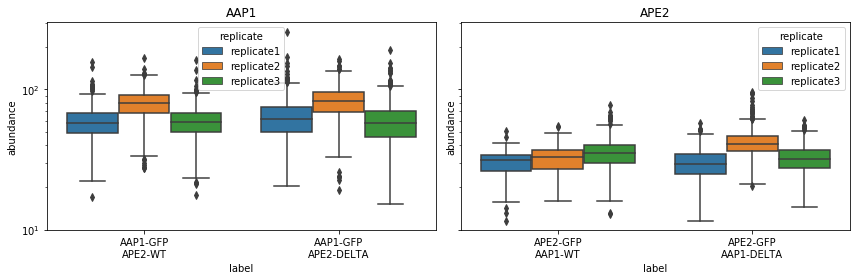

In [101]:
plot_abundance_boxplots(metainfo_pair)

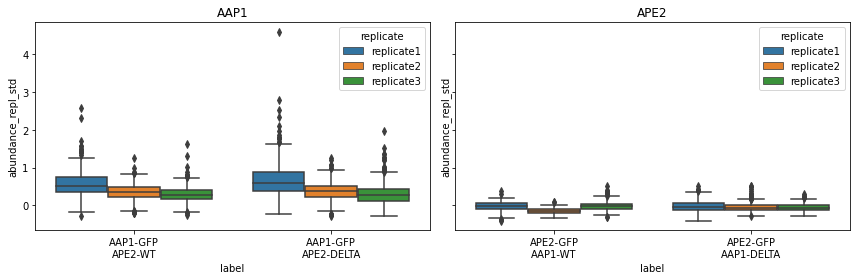

In [48]:
plot_abundance_boxplots(metainfo_pair, y="abundance_repl_std", logscale=False)

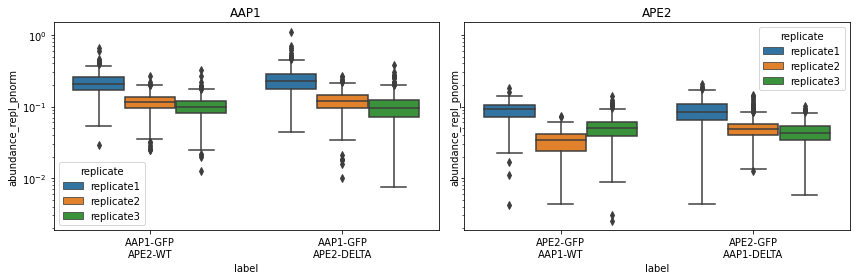

In [102]:
plot_abundance_boxplots(metainfo_pair, y="abundance_repl_pnorm", logscale=True)

Aggregate standardized abundance

In [49]:
aggregated_abundance_std = aggregate_protein_abundance(agg_column='abundance_repl_std')

  0%|          | 0/92 [00:00<?, ?it/s]

In [107]:
aggregated_abundance_std.head()

abundance_repl_std
pairs     replicate  label                                  
AAP1-APE2 replicate1 AAP1-GFP APE2-DELTA            0.678625
                     AAP1-GFP APE2-WT               0.576034
                     APE2-GFP AAP1-DELTA           -0.026532
                     APE2-GFP AAP1-WT              -0.023269
          replicate2 AAP1-GFP APE2-DELTA            0.384327

In [108]:
aggregated_abundance_std.to_csv('../results/protein_abundance_std.csv')

Aggregate percentile normalized abundance

In [103]:
aggregated_abundance_pnorm = aggregate_protein_abundance(agg_column='abundance_repl_pnorm')

  0%|          | 0/92 [00:00<?, ?it/s]

In [104]:
aggregated_abundance_pnorm.head()

abundance_repl_pnorm
pairs     replicate  label                                    
AAP1-APE2 replicate1 AAP1-GFP APE2-DELTA              0.243744
                     AAP1-GFP APE2-WT                 0.221081
                     APE2-GFP AAP1-DELTA              0.087971
                     APE2-GFP AAP1-WT                 0.088692
          replicate2 AAP1-GFP APE2-DELTA              0.121710

In [106]:
aggregated_abundance_pnorm.to_csv('../results/protein_abundance_pnorm.csv')

### Correlation between protein abundance and PCA of NN-extracted features 

#### Features 

In [52]:
features_pair = pd.read_csv(f'../results/predictions-arc/{pair}-features.csv', index_col=0).drop('label', axis=1)
features_pair.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.803845,-1.063626,-0.470264,-0.417291,0.159868,2.193857,0.355372,1.783669,-1.028136,0.786052,...,-0.060393,-0.762097,-0.330148,-0.705988,0.853672,1.299046,-0.019354,1.945260,-2.430594,-0.955674
1,0.269529,0.833618,-0.303484,-1.288153,-0.186532,0.899072,0.059809,0.414781,1.090755,0.867908,...,-0.397714,0.050640,0.527787,-0.249515,1.403761,0.753299,-2.241924,1.653790,-3.107253,-0.534687
2,-0.098850,1.509408,-0.802964,-0.830278,0.268753,-0.088368,0.798738,-0.192084,0.423347,0.029683,...,0.442849,-1.129825,-0.701527,-0.071731,0.516035,0.347986,-1.344414,0.071652,-3.597669,-1.485204
3,-0.398464,2.762806,0.136945,-0.086150,1.020314,0.597819,0.216370,1.089388,1.064613,0.048474,...,0.489981,-1.513579,-0.650922,0.107981,1.440051,0.250051,-2.107182,0.494131,-2.395733,-0.439831
4,-0.991266,1.167365,-0.900481,-1.257962,0.600498,0.264937,0.808625,-0.103103,0.880270,1.139972,...,0.481216,-0.822856,-1.715647,-0.719808,0.434213,0.720799,-1.872080,0.631717,-3.907800,-1.689479


In [53]:
def calculate_pca_abundance_correlation(pair, split=True, abundance_col="abundance"):
    features_pair = pd.read_csv(f'../results/predictions-arc/{pair}-features.csv', index_col=0).drop('label', axis=1)
    metainfo_pair = pd.read_csv(f'../data/meta/metainfo_replicate*_{pair}.csv', index_col=0)
    
    results = []
    if split:
        for gene in metainfo_pair.GFP.unique():
            mask = metainfo_pair.GFP == gene
            pc0 = PCA(n_components=1).fit_transform(features_pair[mask]).flatten()
            r, p = pearsonr(metainfo_pair[abundance_col][mask], pc0)
            results.append({'pair': pair, 'gene': gene, 'n': mask.sum(), 'r': r, 'p': p, 'rabs': np.abs(r)})
    else:
        pc0 = PCA(n_components=1).fit_transform(features_pair).flatten()
        r, p = pearsonr(metainfo_pair.abundance, pc0)
        results.append({'pair': pair, 'r': r, 'n': len(pc0), 'p': p, 'rabs': np.abs(r)})
    return results

In [56]:
res = calculate_pca_abundance_correlation(pair, split=True)

In [59]:
def calculate_pca_abundance_correlation_all_pairs(abundance_col="abundance"):
    metainfo = pd.read_csv('../data/meta/metainfo.csv', sep=',', index_col=0, dtype={'URL': object}).reset_index()
    results = []
    for pair in tqdm(np.unique(metainfo.pairs)):
        if pair.startswith('control'):
            continue
        res = calculate_pca_abundance_correlation(pair, abundance_col=abundance_col)
        results.extend(res)
    return pd.DataFrame(results)

In [58]:
pca_abundance_correlation = calculate_pca_abundance_correlation_all_pairs()

  0%|          | 0/92 [00:00<?, ?it/s]

In [64]:
pca_abundance_correlation.sort_values('rabs', ascending=False)

,pair,gene,n,r,p,rabs
118,RGI1-RGI2,RGI1,6300,0.781621,0.000000e+00,0.781621
112,POR2-POR1,POR2,6192,0.703069,0.000000e+00,0.703069
152,URA5-URA10,URA5,5100,-0.702307,0.000000e+00,0.702307
25,CUE1-CUE4,CUE4,3307,-0.699803,0.000000e+00,0.699803
68,HTA2-HTA1,HTA2,1981,-0.699659,2.828769e-291,0.699659
...,...,...,...,...,...,...
78,KCC4-GIN4,KCC4,1218,0.010451,7.155826e-01,0.010451
67,HER1-GIP3,GIP3,5220,-0.003936,7.761811e-01,0.003936
66,HER1-GIP3,HER1,2678,-0.002968,8.780002e-01,0.002968
110,PHO87-PHO90,PHO87,1850,0.001516,9.480409e-01,0.001516


In [67]:
pca_abundance_correlation.to_csv('../results/pca_abundance_correlation_by_gene.csv')

Same but for standardized values

In [61]:
pca_abundance_correlation_std = calculate_pca_abundance_correlation_all_pairs("abundance_repl_std")

  0%|          | 0/92 [00:00<?, ?it/s]

In [62]:
pca_abundance_correlation_std.sort_values('rabs', ascending=False)

,pair,gene,n,r,p,rabs
118,RGI1-RGI2,RGI1,6300,0.770112,0.000000e+00,0.770112
36,EDC2-EDC1,EDC2,2042,0.744323,0.000000e+00,0.744323
152,URA5-URA10,URA5,5100,-0.727996,0.000000e+00,0.727996
25,CUE1-CUE4,CUE4,3307,-0.722076,0.000000e+00,0.722076
68,HTA2-HTA1,HTA2,1981,-0.705974,8.110134e-299,0.705974
...,...,...,...,...,...,...
24,CUE1-CUE4,CUE1,3958,-0.010264,5.185799e-01,0.010264
56,GPB2-GPB1,GPB2,1233,-0.008157,7.747577e-01,0.008157
115,RCR1-RCR2,RCR2,3531,-0.003561,8.324896e-01,0.003561
26,CUP2-HAA1,CUP2,2912,0.002091,9.101948e-01,0.002091


In [63]:
pca_abundance_correlation_std.to_csv('../results/pca_abundance_correlation_by_gene_std.csv')

Same but for percentile normalized values

In [116]:
pca_abundance_correlation_pnorm = calculate_pca_abundance_correlation_all_pairs("abundance_repl_pnorm")

  0%|          | 0/92 [00:00<?, ?it/s]

In [117]:
pca_abundance_correlation_pnorm.sort_values('rabs', ascending=False)

,pair,gene,n,r,p,rabs
25,CUE1-CUE4,CUE4,3307,-0.719501,0.000000e+00,0.719501
68,HTA2-HTA1,HTA2,1981,-0.704603,3.655299e-297,0.704603
118,RGI1-RGI2,RGI1,6300,0.701015,0.000000e+00,0.701015
112,POR2-POR1,POR2,6192,0.682876,0.000000e+00,0.682876
36,EDC2-EDC1,EDC2,2042,0.641260,6.252687e-237,0.641260
...,...,...,...,...,...,...
128,SAS5-TAF14,SAS5,831,0.003671,9.158573e-01,0.003671
70,ICY2-ICY1,ICY2,3917,-0.003210,8.408233e-01,0.003210
179,YKR078W-VPS5,VPS5,6087,0.001665,8.966753e-01,0.001665
67,HER1-GIP3,GIP3,5220,-0.000873,9.497147e-01,0.000873


In [118]:
pca_abundance_correlation_pnorm.to_csv('../results/pca_abundance_correlation_by_gene_pnorm.csv')

### Relative changes

In [64]:
aggregated_abundance.reset_index().replicate.unique()

array(['replicate1', 'replicate2', 'replicate3'], dtype=object)

In [65]:
aggregated_abundance.head()

abundance
pairs     replicate  label                         
AAP1-APE2 replicate1 AAP1-GFP APE2-DELTA  65.014016
                     AAP1-GFP APE2-WT     59.956622
                     APE2-GFP AAP1-DELTA  30.252105
                     APE2-GFP AAP1-WT     30.412981
          replicate2 AAP1-GFP APE2-DELTA  83.056090

In [70]:
def calculate_relative_changes(aggregated_abundance, abundance_col='abundance'):
    relative_changes = []
    for (pair, replicate), df in tqdm(aggregated_abundance.reset_index().groupby(['pairs', 'replicate'])):
        df = df.reset_index()[['label', abundance_col]]
        df['GFP'] = df['label'].apply(lambda x: x.split('-')[0])
        for gene, group in df.groupby('GFP'):
            if len(group) == 2:
                # Calculate delta / wt intensity ratio
                abundance = group[abundance_col].tolist()
                ratio = abundance[0] / abundance[1]
                relative_changes.append({
                    'GFP': gene,
                    'pair': pair,
                    'replicate': replicate,
                    'ratio': ratio
                })

    return pd.DataFrame(relative_changes)

In [77]:
relative_changes = calculate_relative_changes(aggregated_abundance)
relative_changes.head()

  0%|          | 0/282 [00:00<?, ?it/s]

,GFP,pair,replicate,ratio
0,AAP1,AAP1-APE2,replicate1,1.084351
1,APE2,AAP1-APE2,replicate1,0.994710
2,AAP1,AAP1-APE2,replicate2,1.038387
3,APE2,AAP1-APE2,replicate2,1.271363
4,AAP1,AAP1-APE2,replicate3,1.017135


In [170]:
relative_changes.to_csv('../results/relative_changes.csv')

In [78]:
relative_changes_std = calculate_relative_changes(aggregated_abundance_std, "abundance_repl_std")
relative_changes_std.head()

  0%|          | 0/282 [00:00<?, ?it/s]

,GFP,pair,replicate,ratio
0,AAP1,AAP1-APE2,replicate1,1.178099
1,APE2,AAP1-APE2,replicate1,1.140250
2,AAP1,AAP1-APE2,replicate2,1.091811
3,APE2,AAP1-APE2,replicate2,0.365769
4,AAP1,AAP1-APE2,replicate3,1.044514


In [79]:
relative_changes_std.to_csv('../results/relative_changes_std.csv')

In [109]:
relative_changes_pnorm = calculate_relative_changes(aggregated_abundance_pnorm, "abundance_repl_pnorm")
relative_changes_pnorm.head()

  0%|          | 0/282 [00:00<?, ?it/s]

,GFP,pair,replicate,ratio
0,AAP1,AAP1-APE2,replicate1,1.102510
1,APE2,AAP1-APE2,replicate1,0.991872
2,AAP1,AAP1-APE2,replicate2,1.046202
3,APE2,AAP1-APE2,replicate2,1.463932
4,AAP1,AAP1-APE2,replicate3,1.021371


In [110]:
relative_changes_pnorm.to_csv('../results/relative_changes_pnorm.csv')

In [112]:
def plot_relative_changes(relative_changes, eps=1e-7, annotation_radius=1):
    fig, ax = plt.subplots(figsize=(15, 5))
    relative_changes = relative_changes.dropna()
    coords = np.log(relative_changes['ratio'] + eps)
    # coords = np.log(relative_changes.Avg_intensity_by_area)
    sns.stripplot(x=coords, linewidth=1, ax=ax, jitter=0.2)
    sns.boxplot(x=coords, fliersize=0, whis=3, boxprops=dict(alpha=0.2))

    interesting = []
    for c in ax.collections:
        for name, replicate, of in zip(relative_changes.GFP.tolist(), relative_changes.replicate.tolist(), c.get_offsets()):
            if of[0] < -annotation_radius or of[0] > annotation_radius:
                name = f'{name} (R{replicate[-1]})'
                ax.annotate(name, of)
                interesting.append(name)

    plt.tight_layout()
    ax.set_xlabel('log relative intensity (delta / WT)')
    plt.show()

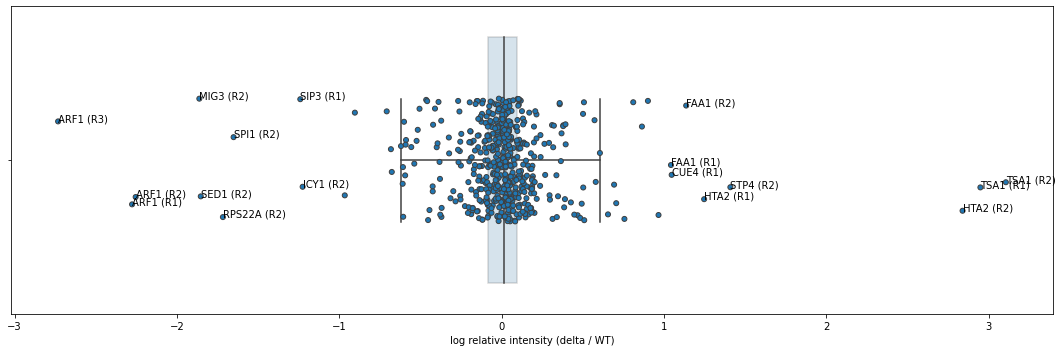

In [84]:
plot_relative_changes(relative_changes)

/gpfs/space/home/papkov/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


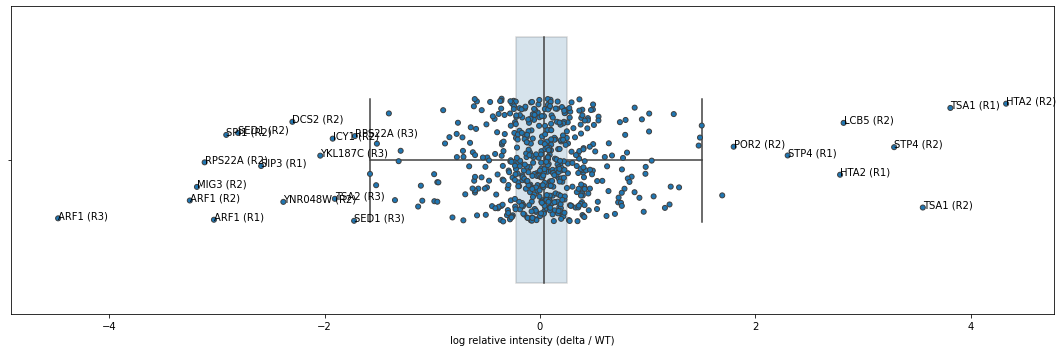

In [119]:
plot_relative_changes(relative_changes_pnorm, annotation_radius=1.7)

/gpfs/space/home/papkov/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


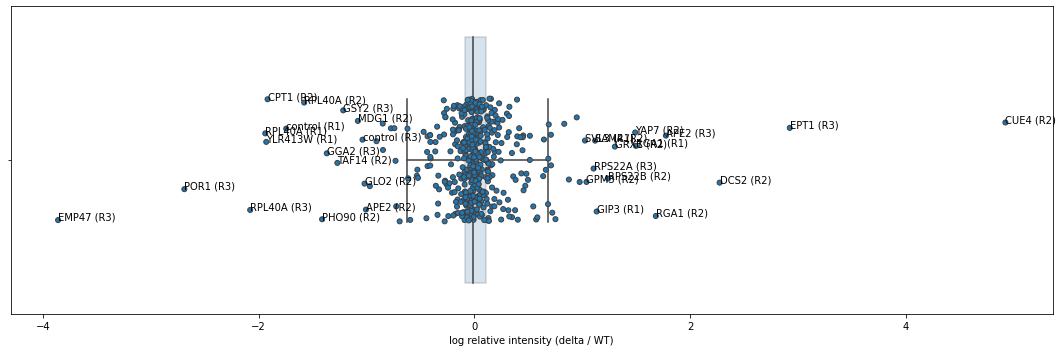

In [85]:
plot_relative_changes(relative_changes_std)